In [0]:
import os
import sys
import math
import random
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from google.colab.patches import cv2_imshow
from sklearn.model_selection import train_test_split


In [0]:

# from tensorflow.keras.layers import *
# from tensorflow.keras.models import Model
# from tensorflow.keras.models import load_model
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, Dense, Flatten

In [0]:
seed = 2019
random.seed = seed
np.random.seed = seed
tf.seed = seed

In [0]:
train_path = "/content/drive/My Drive/capstone_data/"
DIR_BASE="/content/drive/My Drive/Preprocessing/"

In [286]:
images_list = list()

for file in os.listdir(train_path):
    if file.endswith('.jpg'):
        images_list.append(file)

images_list = images_list[:40]
print(len(images_list))

image_size = 224
IMG_WIDTH = 224
IMG_HEIGHT = 224
TEST_SIZE = 0.15
N_CHANNELS   = 3
N_CLASSES = 169
VALID_SIZE  = 0.1765
BATCH_SIZE     = 8
#valid_ids = train_ids[:val_data_size]
#train_ids = train_ids[val_data_size:2000]

#print(len(valid_ids),len(train_ids))

40


In [0]:
# Find color array index
# Interval == 20
def calculate_color_index_interval_20(a, b):
    if (a == 250):
        a = 240
    if (b == 250):
        b = 240
    index = round((a / 20), 0) * 13 + round((b / 20), 0)
    return int(index)
  
# Round Function
def round_numpy_array(numpy_array):
    new_rounded_list = []

    for row in numpy_array:
        new_row = []
        for element in row:
            new_row.append(round(element, -1))
        new_rounded_list.append(new_row)

    return new_rounded_list


# Round and calculate (For Interval of 20)
def round_and_calculate_interval_20(a_list, b_list):
    rounded_a_list = round_numpy_array(a_list.tolist())
    rounded_b_list = round_numpy_array(b_list.tolist())
    index_array = []

    for i in range(0, len(rounded_a_list)):
        new_row = []
        for j in range(0, len(rounded_a_list[i])):
            index = calculate_color_index_interval_20(rounded_a_list[i][j], rounded_b_list[i][j])
            new_row.append(index)
        index_array.append(new_row)

    return index_array


# For Interval 20
def process_image_interval_20(image_path, width, height):
    img = cv2.imread(image_path)  # read image
    img_lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)  # convert from BGR to LAB
    resized_img = cv2.resize(img_lab, (width, height))  # resize image

    # split into L, a and b
    L_array = resized_img[:, :, 0]
    a_array = resized_img[:, :, 1]
    b_array = resized_img[:, :, 2]

    target_array = round_and_calculate_interval_20(a_array, b_array)

    # NumPy data type needs to be 'dtype=np.uint16' or higher
    numpy_target_array = np.array(target_array, dtype=np.uint16)

    return (L_array, numpy_target_array)


def prepare_data(images_list, width, height):
    x_list = list()
    y_list = list()

    for image in images_list:
        image_path = train_path + image
        x, y = process_image_interval_20(image_path, width, height)
        x_BGR = cv2.cvtColor(x, cv2.COLOR_GRAY2BGR)  # cloned 1 channel to 3 channel for model input
        x_list.append(x_BGR)
        y_list.append(y)

    return x_list, y_list


def split_data_train_test(x_list, y_list, test_size):
    x_train, x_test, y_train, y_test = train_test_split(x_list, y_list, test_size=test_size)

    np.save(DIR_BASE + "x_train.npy", x_train)
    np.save(DIR_BASE + "y_train.npy", y_train)
    np.save(DIR_BASE + "x_test.npy", x_test)
    np.save(DIR_BASE + "y_test.npy", y_test)

In [0]:
x_list, y_list = prepare_data(images_list, IMG_WIDTH, IMG_HEIGHT)
split_data_train_test(x_list, y_list, TEST_SIZE)

In [289]:

x_train = np.load(file=DIR_BASE+"x_train.npy", allow_pickle=True)
y_train = np.load(file=DIR_BASE+"y_train.npy", allow_pickle=True)
print(x_train.shape)
print(y_train.shape)

(34, 224, 224, 3)
(34, 224, 224)


In [290]:

x_test = np.load(file=DIR_BASE+"x_test.npy", allow_pickle=True)
y_test = np.load(file=DIR_BASE+"y_test.npy", allow_pickle=True)
print(x_test.shape)
print(y_test.shape)

(6, 224, 224, 3)
(6, 224, 224)


In [0]:
class CustomDataGenerator(tf.keras.utils.Sequence):

        def __init__(self, x_set, y_set, batch_size, num_classes=N_CLASSES):
            self.x, self.y = x_set, y_set
            self.batch_size = batch_size
            self.n_classes = num_classes

        def __len__(self):
            return math.ceil(len(self.x) / self.batch_size)

        def __getitem__(self, idx):
            batch_x = self.x[idx * self.batch_size:(idx + 1) *
            self.batch_size]
            batch_y = self.y[idx * self.batch_size:(idx + 1) *
            self.batch_size]

            batch_y = tf.keras.utils.to_categorical(y=batch_y, 
                                                    num_classes=self.n_classes)
            
            return batch_x, batch_y



In [0]:
training_generator = CustomDataGenerator(x_train, y_train, batch_size=BATCH_SIZE)
validation_generator = CustomDataGenerator(x_test, y_test, batch_size=BATCH_SIZE)

In [0]:
def bn_act(x, act=True):
    x = keras.layers.BatchNormalization()(x)
    if act == True:
        x = keras.layers.Activation("relu")(x)
    return x

def conv_block(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    conv = bn_act(x)
    conv = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides)(conv)
    return conv

def stem(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    conv = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides)(x)
    conv = conv_block(conv, filters, kernel_size=kernel_size, padding=padding, strides=strides)
    
    shortcut = keras.layers.Conv2D(filters, kernel_size=(1, 1), padding=padding, strides=strides)(x)
    shortcut = bn_act(shortcut, act=False)
    
    output = keras.layers.Add()([conv, shortcut])
    return output

def residual_block(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    res = conv_block(x, filters, kernel_size=kernel_size, padding=padding, strides=strides)
    res = conv_block(res, filters, kernel_size=kernel_size, padding=padding, strides=1)
    
    shortcut = keras.layers.Conv2D(filters, kernel_size=(1, 1), padding=padding, strides=strides)(x)
    shortcut = bn_act(shortcut, act=False)
    
    output = keras.layers.Add()([shortcut, res])
    return output

def upsample_concat_block(x, xskip):
    u = keras.layers.UpSampling2D((2, 2))(x)
    c = keras.layers.Concatenate()([u, xskip])
    return c


In [0]:
def ResUNet():
    f = [16, 32, 64, 128, 256]
    inputs = keras.layers.Input((image_size, image_size, 3))
    
    ## Encoder
    e0 = inputs
    e1 = stem(e0, f[0])
    e2 = residual_block(e1, f[1], strides=2)
    e3 = residual_block(e2, f[2], strides=2)
    e4 = residual_block(e3, f[3], strides=2)
    e5 = residual_block(e4, f[4], strides=2)
    
    ## Bridge
    b0 = conv_block(e5, f[4], strides=1)
    b1 = conv_block(b0, f[4], strides=1)
    
    ## Decoder
    u1 = upsample_concat_block(b1, e4)
    d1 = residual_block(u1, f[4])
    
    u2 = upsample_concat_block(d1, e3)
    d2 = residual_block(u2, f[3])
    
    u3 = upsample_concat_block(d2, e2)
    d3 = residual_block(u3, f[2])
    
    u4 = upsample_concat_block(d3, e1)
    d4 = residual_block(u4, f[1])
    
    outputs = keras.layers.Conv2D(1, (1, 1), padding="same", activation="sigmoid")(d4)
    model = keras.models.Model(inputs, outputs)
    return model


In [0]:
smooth = 1.

def dice_coeff(y_true,y_pred):
    y_true_f=tf.keras.layers.Flatten()(y_true)
    y_pred_f=tf.keras.layers.Flatten()(y_pred)
    intersection=tf.reduce_sum(y_true_f*y_pred_f)
    return(2.*intersection+smooth)/(tf.reduce_sum(y_true_f)+tf.reduce_sum(y_pred_f)+smooth)

def dice_coeff_loss(y_true,y_pred):
    return 1.0-dice_coeff(y_true,y_pred)


In [296]:
model = ResUNet()
adam = keras.optimizers.Adam()
model.compile(optimizer=adam, loss=dice_coef_loss, metrics=[dice_coef])
model.summary()


Model: "model_13"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_14 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_390 (Conv2D)             (None, 224, 224, 16) 448         input_14[0][0]                   
__________________________________________________________________________________________________
batch_normalization_364 (BatchN (None, 224, 224, 16) 64          conv2d_390[0][0]                 
__________________________________________________________________________________________________
activation_247 (Activation)     (None, 224, 224, 16) 0           batch_normalization_364[0][0]    
___________________________________________________________________________________________

In [297]:
# train_gen = training_generator
# valid_gen = validation_generator

#train_steps = len(train_ids)//batch_size
#valid_steps = len(valid_ids)//batch_size

epochs = 10

print(tf.__version__)
#model.fit_generator(generator=training_generator, validation_data=validation_generator, epochs=1)

model.fit(x=training_generator, validation_data=validation_generator, epochs=epochs)

2.2.0-rc3
Epoch 1/10


InvalidArgumentError: ignored

In [0]:
model.save_weights("ResUNet.h5")


  Ground Truth  Predicted Value


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  if __name__ == '__main__':


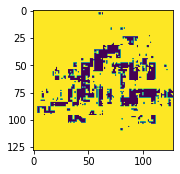

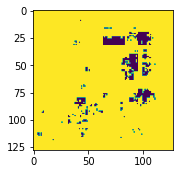

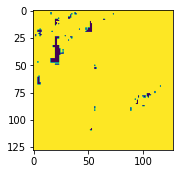

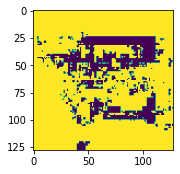

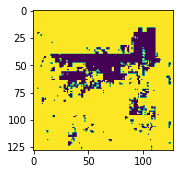

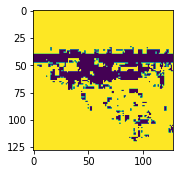

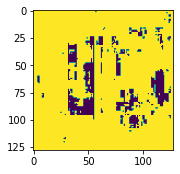

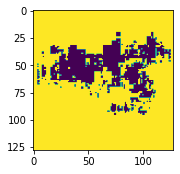

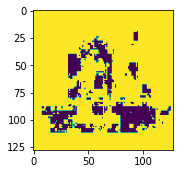

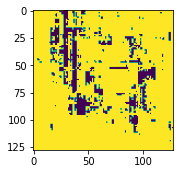

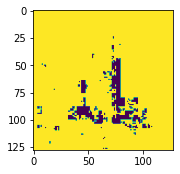

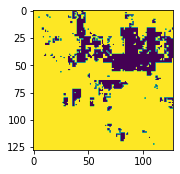

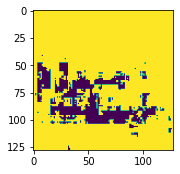

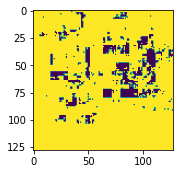

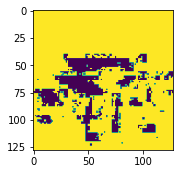

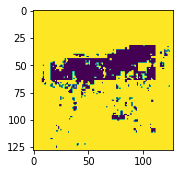

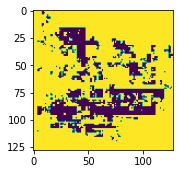

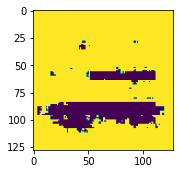

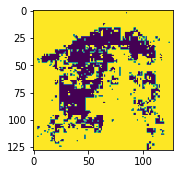

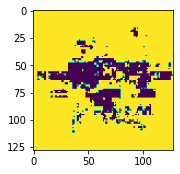

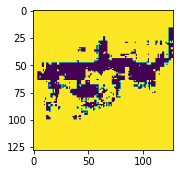

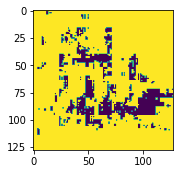

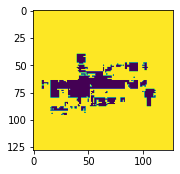

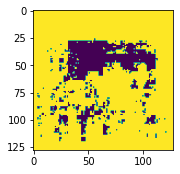

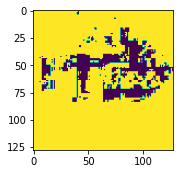

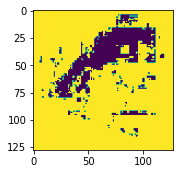

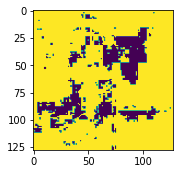

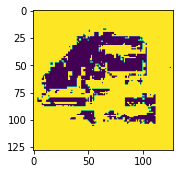

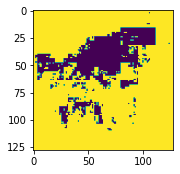

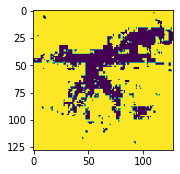

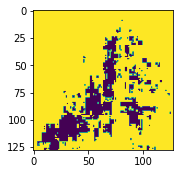

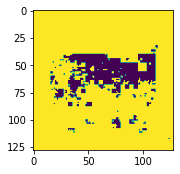

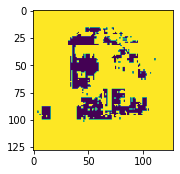

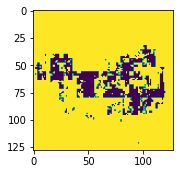

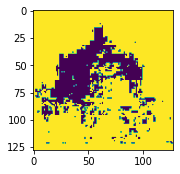

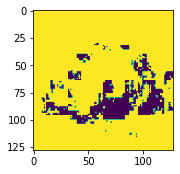

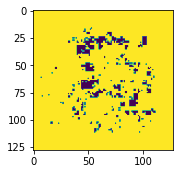

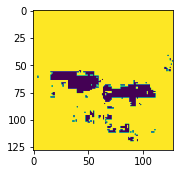

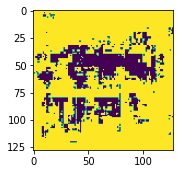

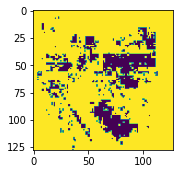

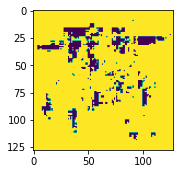

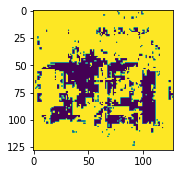

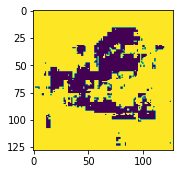

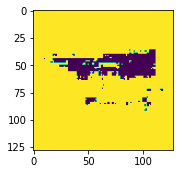

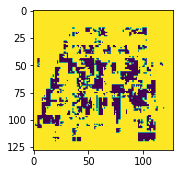

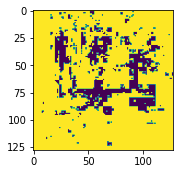

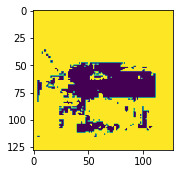

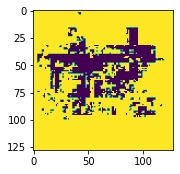

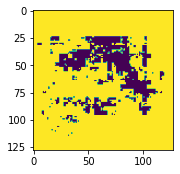

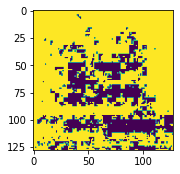

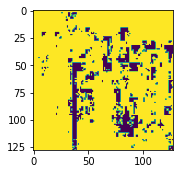

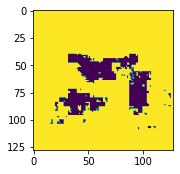

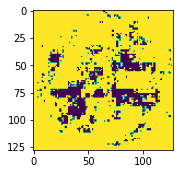

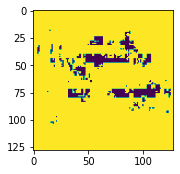

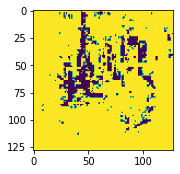

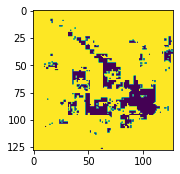

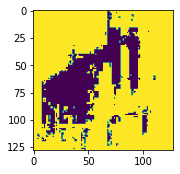

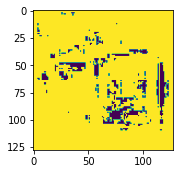

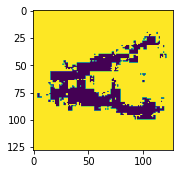

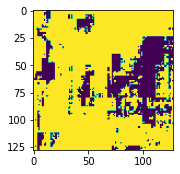

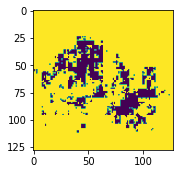

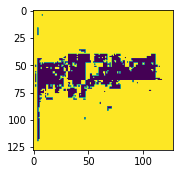

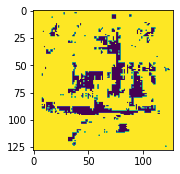

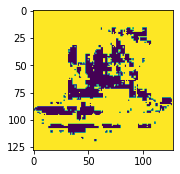

In [124]:
print("\n  Ground Truth  Predicted Value")

for i in range(1,5,1):
    x = valid_gen.__getitem__(i)
    result = model.predict(x)
    result = result > 0.4

    for i in range(len(result)):
        fig = plt.figure()
        fig.subplots_adjust(hspace=0.4,wspace=0.4)

        #ax = fig.add_subplot(1,2,1)
        #ax.imshow(np.reshape(y[i]*255,(image_size,image_size)),cmap='gray')

        ax = fig.add_subplot(1,2,2)
        ax.imshow(np.reshape(result[i]*255,(image_size,image_size)))

In [84]:
print("loss = "  )
print("test Accuracy = " )

NameError: ignored

In [85]:
model.summary()

NameError: ignored